In [2]:
from folium.plugins import MarkerCluster
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import textwrap
import folium
import random
import os



In [4]:
chunk_size = 100000  # Adjust based on available memory
all_data_frame = {
    "raw_data_file_frame": "",
    "cleaned_data_file_frame":"",
    "fl_data_frame": "",
    "ca_data_frame":"",
    "ny_data_frame":""
}

raw_file_path = r"..\data\US_Accidents_March23.csv"
fl_data_file = r"..\data\processed_data_file\data_by_state\FL_org.csv"
ca_data_file = r"..\data\processed_data_file\data_by_state\CA_org.csv"
va_data_file = r"..\data\processed_data_file\data_by_state\VA_org.csv"
ny_data_file = r"..\data\processed_data_file\data_by_state\NY_org.csv"
all_data_file = r"..data\processed_data_file\raw_cleaned_data\cleaned_all_state_data.csv"
output_dir_raw_clean_data = r"..\data\processed_data_file\raw_cleaned_data"
output_dir_cleaned_data_by_state = r"..\data\processed_data_file\data_by_state"

In [5]:
USA_2023_POPULATION_DATA = {
    "State": [
        "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY",
        "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH",
        "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
    ],
    "Population": [
        3977628, 557899, 5848310, 2362124, 30519524, 4662926, 2894190, 819952, 552380, 18229883,
        8490546, 1141525, 1497384, 9844167, 5274945, 2476882, 2246209, 3509259, 3506600, 1146670,
        4818337, 5659598, 7925350, 4436981, 2259864, 4821686, 897161, 1497381, 2508220, 1150004,
        7280551, 1663024, 15611308, 8498868, 599192, 9207681, 3087217, 3401528, 10332678, 892124,
        4229354, 697420, 5555761, 22942176, 2484582, 532828, 6834154, 6164810, 1417859, 4661826, 454508
    ]
}
usa_2023_population_age_18_and_up_data_frame = pd.DataFrame(USA_2023_POPULATION_DATA)

In [7]:
""""
This section is used to load the raw data frame, process the data and save the processed data based on state. 
This section also initializes the data frame objects, which will be used in further analysis
"""

def read_large_csv(file_path, chunk_size):
    """Reads a large CSV file in chunks and returns a generator of chunks."""
    return pd.read_csv(file_path, chunksize=chunk_size, low_memory=False)


def process_large_csv(file_path, chunk_size=100000):
    """Processes the large CSV file and returns the cleaned DataFrame."""
    df_combined = pd.DataFrame()

    for chunk in read_large_csv(file_path, chunk_size):
        df_combined = pd.concat([df_combined, chunk], ignore_index=True)

    return df_combined

def init_state_data_frames():
    print("*** initialize data frame for CA,FL and NY ******* ")
    all_data_frame["fl_data_frame"] = process_large_csv(fl_data_file)
    all_data_frame["ca_data_frame"] = process_large_csv(ca_data_file)
    all_data_frame["ny_data_frame"] = process_large_csv(ny_data_file)

def drop_columns(data_frame):
    cols_to_drop = ['ID', 'Source', 'End_Lat', 'End_Lng', 'Distance(mi)', 
                    'Description', 'Airport_Code', 'Pressure(in)', 
                    'Wind_Direction', 'Precipitation(in)', 
                    'Amenity','Give_Way', 'No_Exit', 'Traffic_Calming', 
                    'Turning_Loop', 'Nautical_Twilight', 'Astronomical_Twilight',
                    'Civil_Twilight','Airport_Code','Sunrise_Sunset', 'Wind_Chill(F)'
                    ]
    return data_frame.drop(cols_to_drop, axis=1)


def split_and_save_by_state(data_frame):
    """Splits data by state and saves it into separate CSV files."""
    os.makedirs(output_dir_cleaned_data_by_state, exist_ok=True)

    for state, state_df in data_frame.groupby("State"):
        if (state == 'FL' or state == 'CA' or state == 'VA' or state == 'NY') :
            state_file = os.path.join(output_dir_cleaned_data_by_state, f"{state}_org.csv")
            state_df.to_csv(state_file, index=False)
    print(f"Data saved for FA, CA, VA, NY \n ")


def save_cleaned_raw_data(data_frame):
    os.makedirs(output_dir_raw_clean_data, exist_ok=True)
    filePath = os.path.join(output_dir_raw_clean_data, "cleaned_all_state_data.csv")
    data_frame.to_csv(filePath, index=False)
    print(f"Saved Cleaned all state Data  \n ")


def data_preprocessing_and_cleanup (data_frame):
    print(" *****************  Starting Data Preprocessing and Cleanup  **************")
    data_frame = data_frame[data_frame["Source"].str.lower() == "source1"]
    data_frame = drop_columns(data_frame)

    missing_data = pd.DataFrame(data_frame.isnull().sum()).reset_index()
    missing_data.columns = ['Feature', 'Missing_Percent(%)']
    missing_data['Missing_Percent(%)'] = missing_data['Missing_Percent(%)'].apply(lambda x: x / data_frame.shape[0] * 100)
    missing_data.loc[missing_data['Missing_Percent(%)']>0,:]
    data_frame = data_frame.dropna(subset=['City','Zipcode','Street',
                        'Zipcode','County','Timezone','Weather_Timestamp'])

    data_frame.dropna(inplace = True)
    return data_frame


def print_basic_summary(data_frame, state=''):
    print(f"***  Printing Basic Data Frame Summary: {state} ****")
    print(" \n Unique Source: ", data_frame['Source'].unique())
    print(" \n Unique State: ", data_frame['State'].unique())
    print("\n The shape of data frame is:",(data_frame.shape))
    print("\n Data frame info: \n",data_frame.info())


def print_summary(data_frame, state=''):
    print(f"***  Printing Data Frame Summary: {state} **** \n")
    print(f"{data_frame.info()}")
    print(f"***  Data Frame description **** \n")
    print(data_frame.describe(include="all"))
    print("\n The shape of data is:",(data_frame.shape))
    print("\n Top 3 records \n")
    display(data_frame.head(3))



In [8]:
all_data_frame["raw_data_file_frame"] = process_large_csv(raw_file_path)
print_basic_summary(all_data_frame["raw_data_file_frame"] , state='Raw Data')
all_data_frame["cleaned_data_file_frame"] = data_preprocessing_and_cleanup (all_data_frame["raw_data_file_frame"])
print_summary(all_data_frame["cleaned_data_file_frame"], state='Cleaned Raw Data')
save_cleaned_raw_data(all_data_frame["cleaned_data_file_frame"])
split_and_save_by_state(all_data_frame["cleaned_data_file_frame"])
init_state_data_frames()


***  Printing Basic Data Frame Summary: Raw Data ****
 
 Unique Source:  ['Source2' 'Source3' 'Source1']
 
 Unique State:  ['OH' 'WV' 'CA' 'FL' 'GA' 'SC' 'NE' 'IA' 'IL' 'MO' 'WI' 'IN' 'MI' 'NJ'
 'NY' 'CT' 'MA' 'RI' 'NH' 'PA' 'KY' 'MD' 'VA' 'DC' 'DE' 'TX' 'WA' 'OR'
 'AL' 'NC' 'AZ' 'TN' 'LA' 'MN' 'CO' 'OK' 'NV' 'UT' 'KS' 'NM' 'AR' 'MS'
 'ME' 'VT' 'WY' 'ID' 'ND' 'MT' 'SD']

 The shape of data frame is: (7728394, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 1

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Street,City,County,State,Zipcode,...,Wind_Speed(mph),Weather_Condition,Bump,Crossing,Junction,Railway,Roundabout,Station,Stop,Traffic_Signal
3402762,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,Outerbelt E,Dublin,Franklin,OH,43017,...,10.4,Light Rain,False,False,False,False,False,False,False,False
3402767,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,I-75 S,Cincinnati,Hamilton,OH,45217,...,10.4,Light Rain,False,False,False,False,False,False,False,False
3402768,2,2016-02-08 08:16:57,2016-02-08 14:16:57,39.063240,-84.032430,State Route 32,Williamsburg,Clermont,OH,45176,...,8.1,Overcast,False,False,False,False,False,False,False,True


Saved Cleaned all state Data  
 
Data saved for FA, CA, VA, NY 
 
*** initialize data frame for CA,FL and NY ******* 


# EDA US All State

#### USA Map based on accident count

In [9]:
def plot_us_map_accident_count(data_frame):
    state_counts = data_frame["State"].value_counts().reset_index()
    state_counts.columns = ["State", "Accidents"]

    fig = px.choropleth(
        state_counts, 
        locations="State", 
        locationmode="USA-states", 
        color="Accidents",
        color_continuous_scale="reds",
        title="Number of US Accidents for each State"
    )
    fig.update_layout(geo=dict(scope="usa"))
    fig.show()

plot_us_map_accident_count(all_data_frame["cleaned_data_file_frame"])


In [ ]:


def plot_histogram_weather_condition_vs_accident_count(data_frame, state=''):
    """Analyzes the state-wise accident count and plots a histogram."""
    weather_condition = data_frame["Weather_Condition"].value_counts()
    
    plt.figure(figsize=(25, 20))
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))   
    weather_condition.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.xlabel("Weather")
    plt.ylabel("Total Accidents")
    plt.title(f"Total Accidents by weather condition: {state}")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


def plot_histogram_top_20_city_accident_count(data_frame, state=""):

    # Get the top 20 cities with the highest number of accidents
    top_cities = data_frame["City"].value_counts().sort_values()[-20:].reset_index()
    top_cities.columns = ["city", "number_of_accidents"]

    # Plot the bar chart
    plt.figure(figsize=(20,7))
    sns.barplot(x="city", y="number_of_accidents", hue="city", data=top_cities, palette='Set2', legend=False)
    plt.title(f"TOP 20 CITIES WITH HIGHEST NUMBER OF ACCIDENTS - {state}", fontsize=20)
    plt.xticks(rotation=40)
    plt.show()


# accedent_data_frame
def plot_stacked_bar_chart_state_sev_population(accedent_data_frame, population_data_frame):

    # Count accidents per state per severity level
    severity_counts = accedent_data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)
    
    # Merge with population data
    merged_df = population_data_frame.merge(severity_counts, on="State", how="left").fillna(0)
    
    # Define colors for severity levels
    severity_colors = {1: "#a6cee3", 2: "#1f78b4", 3: "#b2df8a", 4: "#33a02c"}

    # Plot stacked bar chart
    ax = merged_df.set_index("State")[sorted(severity_counts.columns)].plot(
        kind="bar", stacked=True, figsize=(14, 7), color=[severity_colors[s] for s in sorted(severity_counts.columns)]
    )

    # Labels and title
    plt.xlabel("State")
    plt.ylabel("Number of Accidents")
    plt.title("Accidents count vs State and Severity Level")
    plt.xticks(rotation=45, ha="right")
    
    # Add legend
    plt.legend(title="Severity Level", loc="upper right")

    # Show plot
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_bubble_chart(accedent_data_frame, population_data_frame):
    # Aggregate accident count and average severity per state
    accident_summary = accedent_data_frame.groupby("State").agg(
        Accidents=("State", "count"),
        Avg_Severity=("Severity", "mean")
    ).reset_index()

    # Merge with population data
    merged_df = pd.merge(accident_summary, population_data_frame, on="State")

    # Normalize population size for better bubble visualization
    pop_scaled = merged_df["Population"] / 50000  # Adjusting scale for better visibility

    # Create Bubble Chart
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        merged_df["Population"], 
        merged_df["Accidents"], 
        s=pop_scaled,  # Bubble size based on population
        c=merged_df["Avg_Severity"],  # Color based on severity
        cmap="Reds", 
        alpha=0.7,
        edgecolors="k"
    )

    # Add state labels on each bubble
    for i, row in merged_df.iterrows():
        plt.text(row["Population"], row["Accidents"], row["State"], fontsize=10, ha='center', va='center', color="black")

    # Add color bar for severity
    cbar = plt.colorbar(scatter)
    cbar.set_label("Average Severity (1=Low, 4=High)")

    # Labels and title
    plt.xlabel("State Population")
    plt.ylabel("Number of Accidents")
    plt.title("Bubble Chart of Accidents vs. Population (Scaled by Population & Colored by Severity)")

    # Grid for better readability
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show plot
    plt.show()


def plot_paginated_accident_percentage_improved(accident_data_frame, population_data_frame, states_per_page=4):

    # Aggregate accident count per state and severity
    accident_summary = accident_data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)

    # Merge with population data
    merged_df = population_data_frame.merge(accident_summary, on="State", how="left").fillna(0)

    # Calculate accident percentage per severity level
    for severity in sorted(accident_summary.columns):
        merged_df[f"Severity_{severity}_Percentage"] = (merged_df[severity] / merged_df["Population"]) * 100

    # Sort states by population (descending)
    merged_df = merged_df.sort_values(by="Population", ascending=False)

    # Define severity colors
    severity_colors = {1: "#a6cee3", 2: "#1f78b4", 3: "#b2df8a", 4: "#33a02c"}

    # Paginate the states into batches
    total_states = len(merged_df)
    for start in range(0, total_states, states_per_page):
        end = min(start + states_per_page, total_states)
        subset_df = merged_df.iloc[start:end]

        # Determine subplot grid size
        num_states = len(subset_df)
        cols = 2  # Maximum 2 columns for better readability
        rows = int(np.ceil(num_states / cols))  # Auto-adjust row count

        # Adjust figure size dynamically
        fig_height = max(4, rows * 2.5)  # Ensure proper spacing
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, fig_height))
        axes = np.array(axes).reshape(-1)  # Flatten for easy indexing

        # Generate bar plots for each state
        for idx, row in enumerate(subset_df.itertuples()):
            state = row.State
            population = row.Population
            severity_percentages = [getattr(row, f"Severity_{s}_Percentage") for s in sorted(accident_summary.columns)]

            # Plot bars
            bars = axes[idx].bar(
                sorted(accident_summary.columns),
                severity_percentages,
                color=[severity_colors[s] for s in sorted(accident_summary.columns)]
            )

            # Adjust y-axis limits to ensure no overlap
            max_percentage = max(severity_percentages) if severity_percentages else 0
            axes[idx].set_ylim(0, max_percentage * 1.3)  # Add space above bars

            # Add title with population info, ensuring no overlap with bars
            axes[idx].text(0.5, 1.15, f"{state}\nPop: {population:,}", fontsize=10, fontweight="bold",
                           ha='center', va='top', transform=axes[idx].transAxes)

            axes[idx].set_xlabel("Severity Level")
            axes[idx].set_ylabel("Accident % of Population")
            axes[idx].set_xticks(sorted(accident_summary.columns))

            # Add percentage annotations on bars with dynamic vertical placement
            for bar, percent in zip(bars, severity_percentages):
                height_adjustment = max_percentage * 0.05  # Adjust placement dynamically
                axes[idx].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + height_adjustment,
                               f"{percent:.2f}%", ha='center', va='bottom', fontsize=8, color="black")

        # Hide any unused subplots (if fewer states than grid size)
        for i in range(idx + 1, len(axes)):
            fig.delaxes(axes[i])

        # Show the current page of subplots
        plt.suptitle(f"Accident Percentage by Severity Level per State (Sorted by Population)\nPage {start // states_per_page + 1}", 
                     fontsize=14, fontweight="bold")
        plt.tight_layout()  # Ensures spacing is adjusted properly
        plt.show()

### Accident count by state

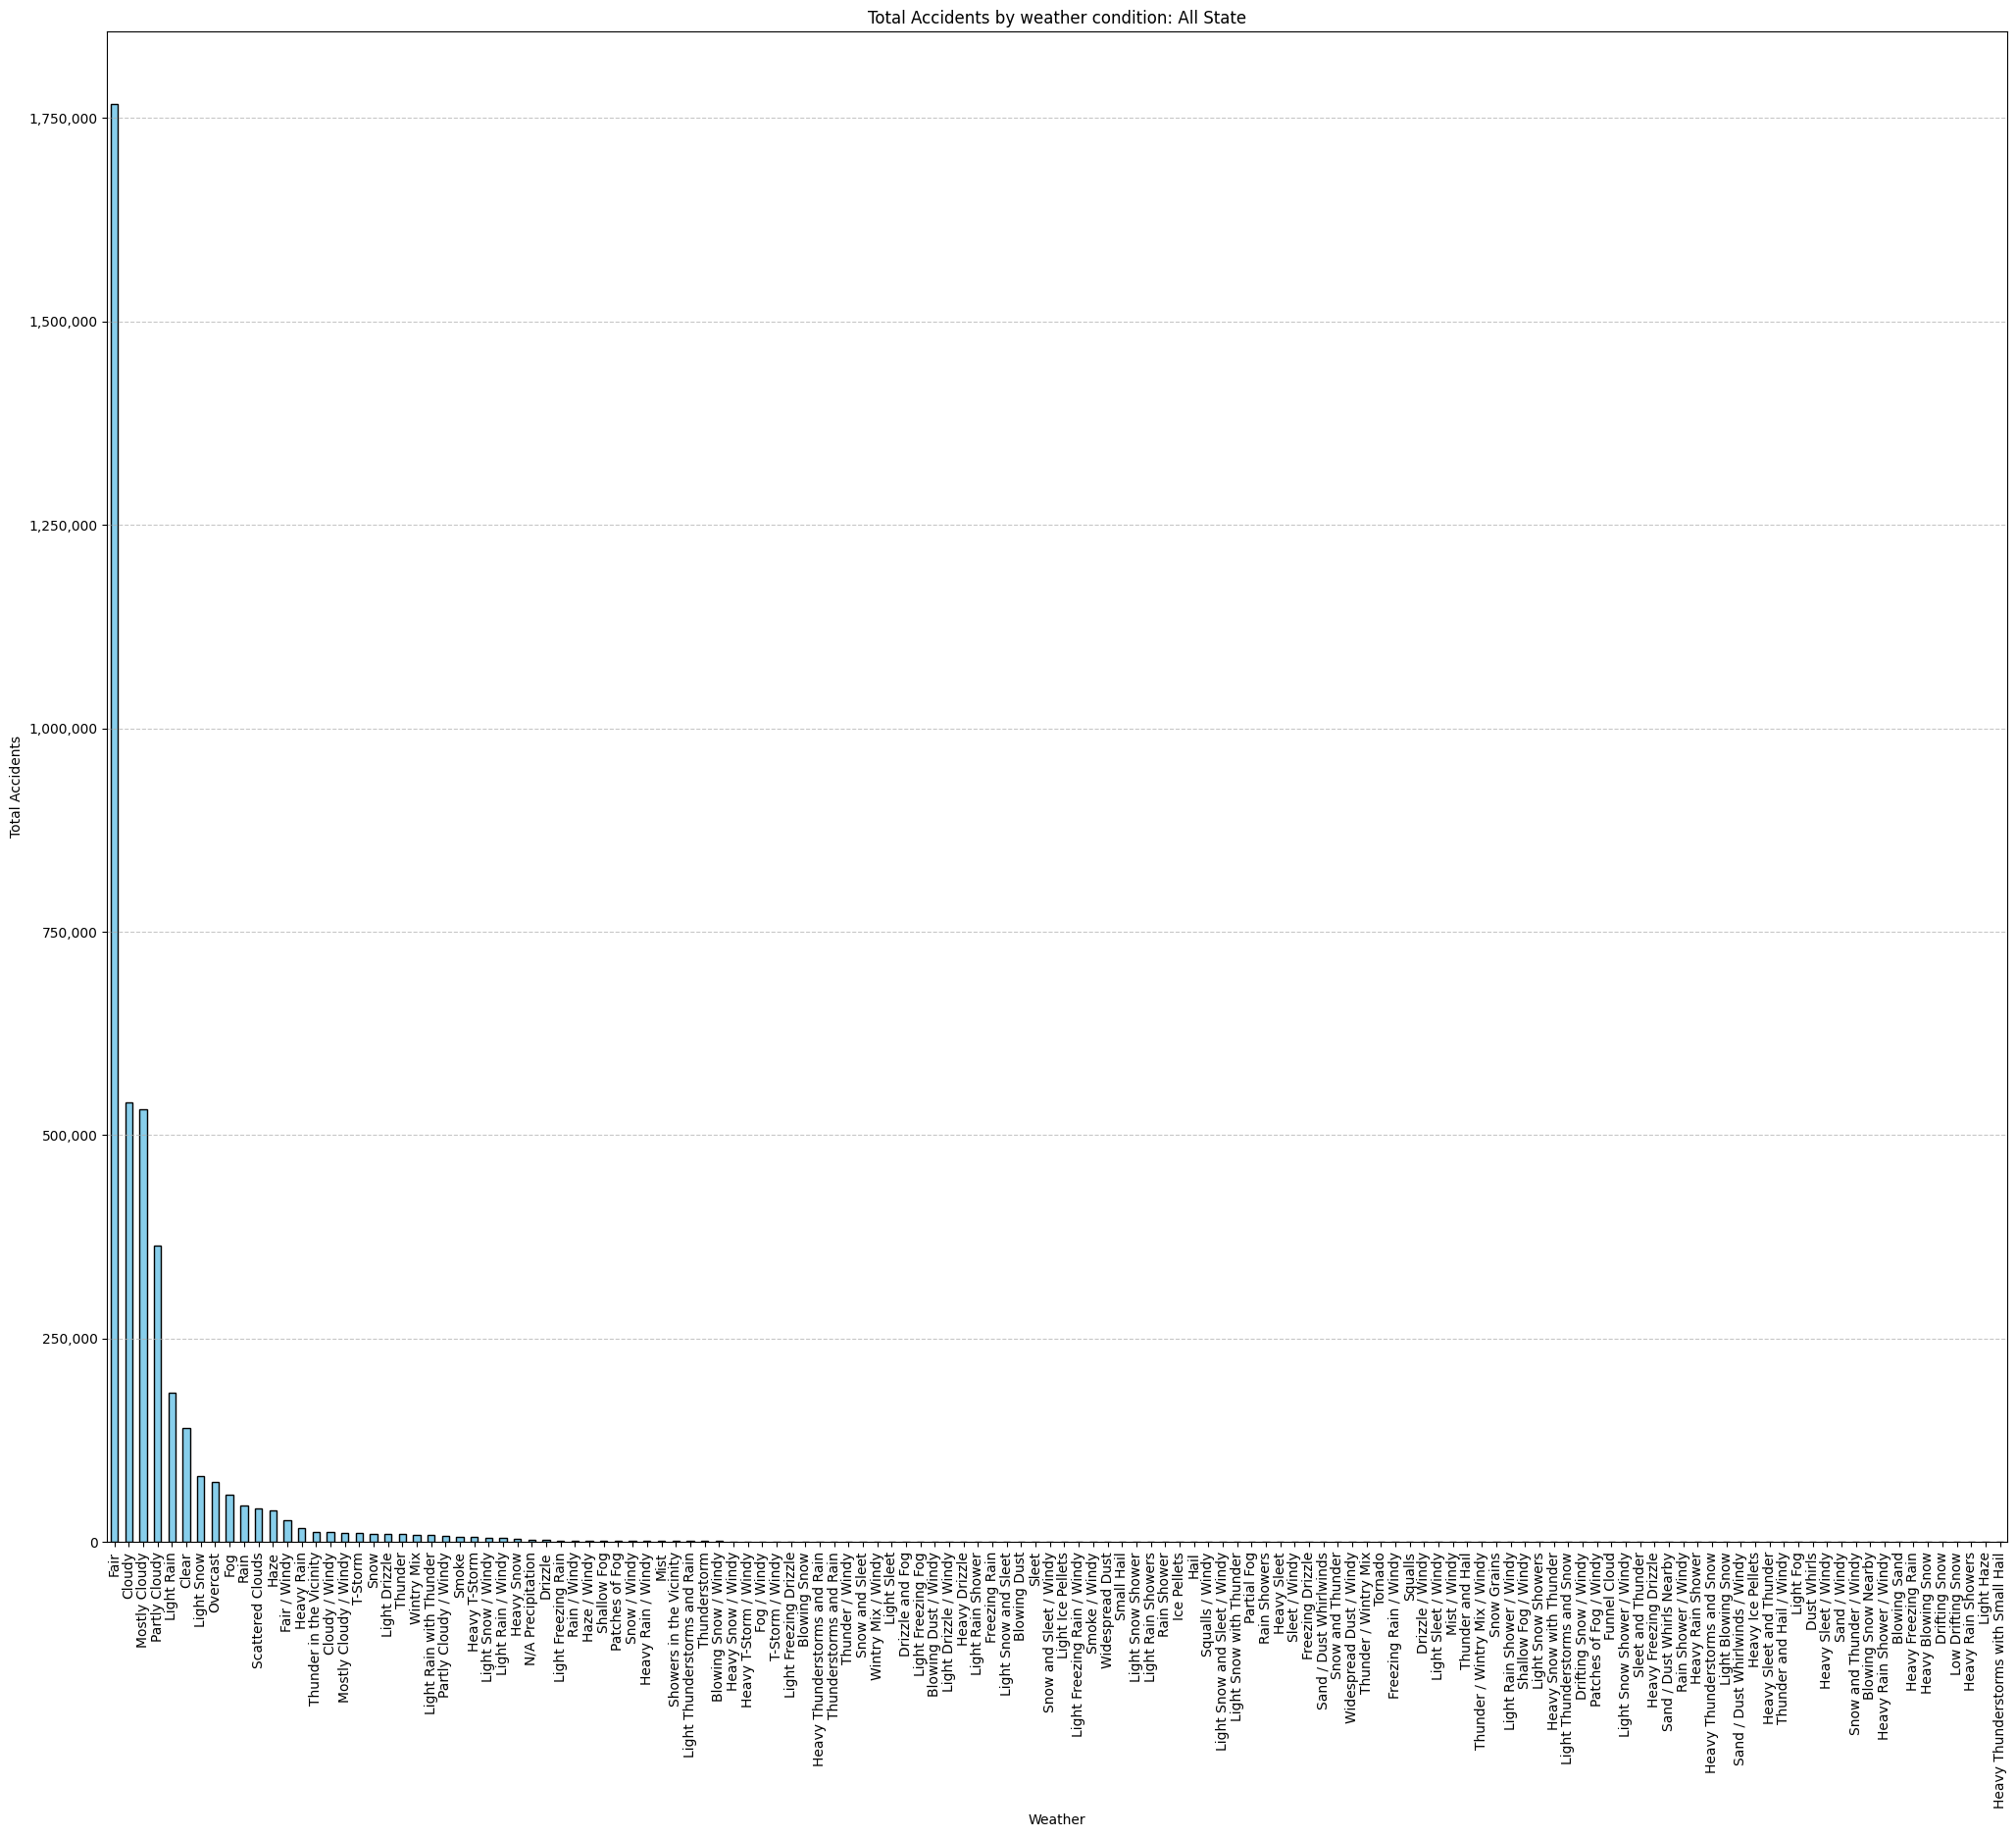

In [15]:
plot_histogram_weather_condition_vs_accident_count(all_data_frame["cleaned_data_file_frame"], "All State")


### TOP 20 City

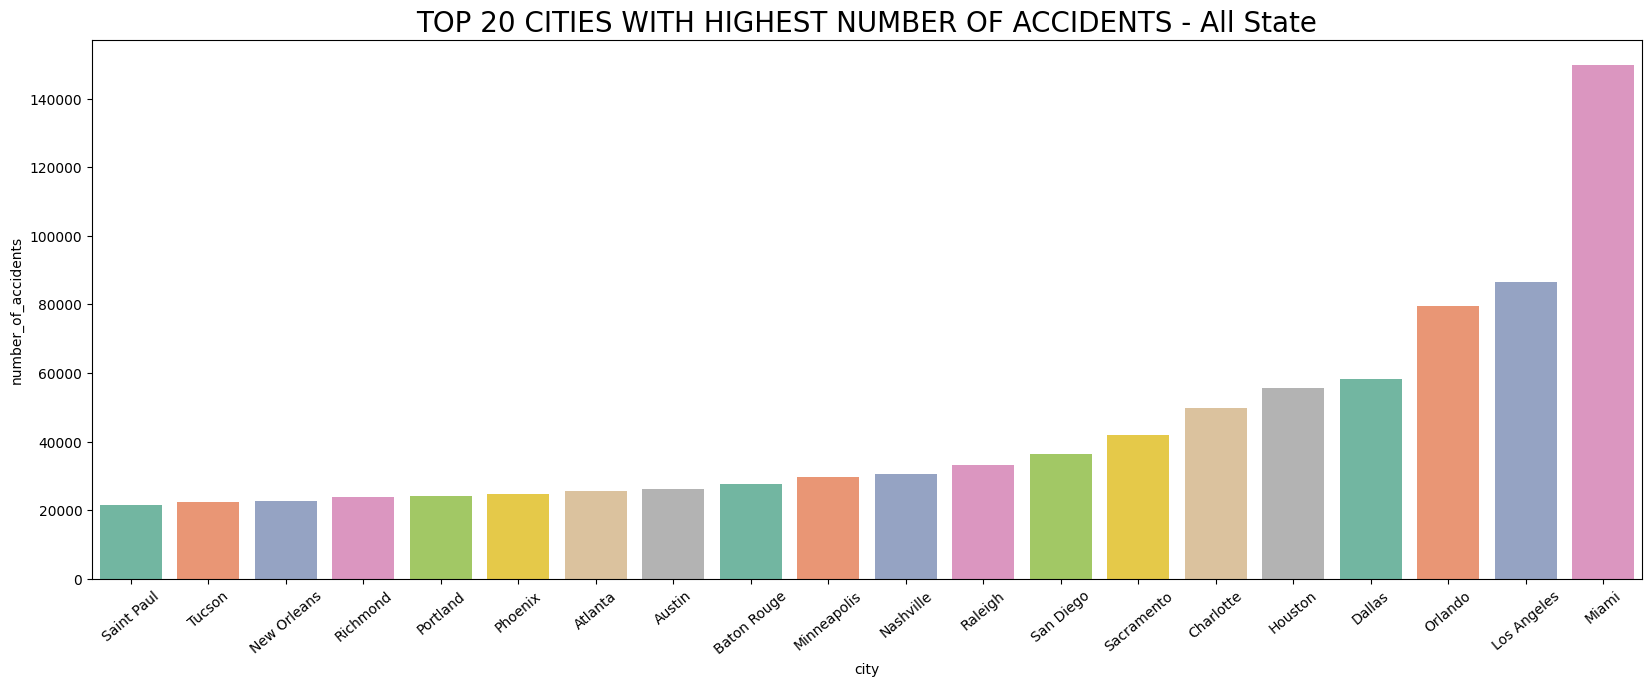

In [20]:
plot_histogram_top_20_city_accident_count(all_data_frame["cleaned_data_file_frame"], "All State")

### Accident Sev level on each state and count

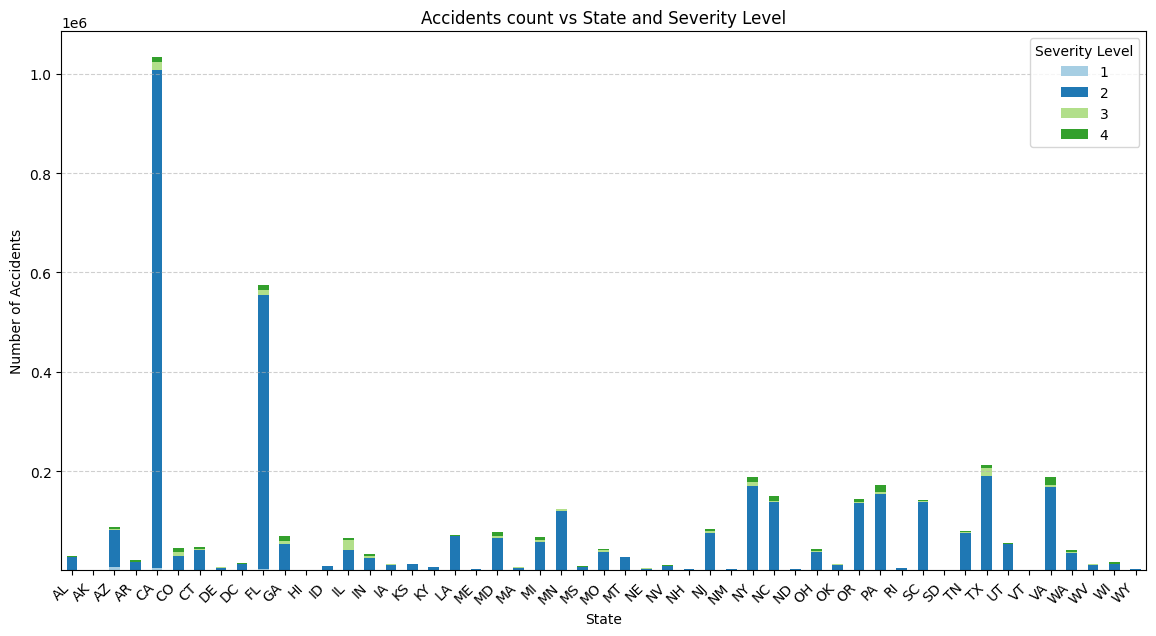

In [23]:
plot_stacked_bar_chart_state_sev_population(all_data_frame["cleaned_data_file_frame"], usa_2023_population_age_18_and_up_data_frame)


### Accident Sev and state

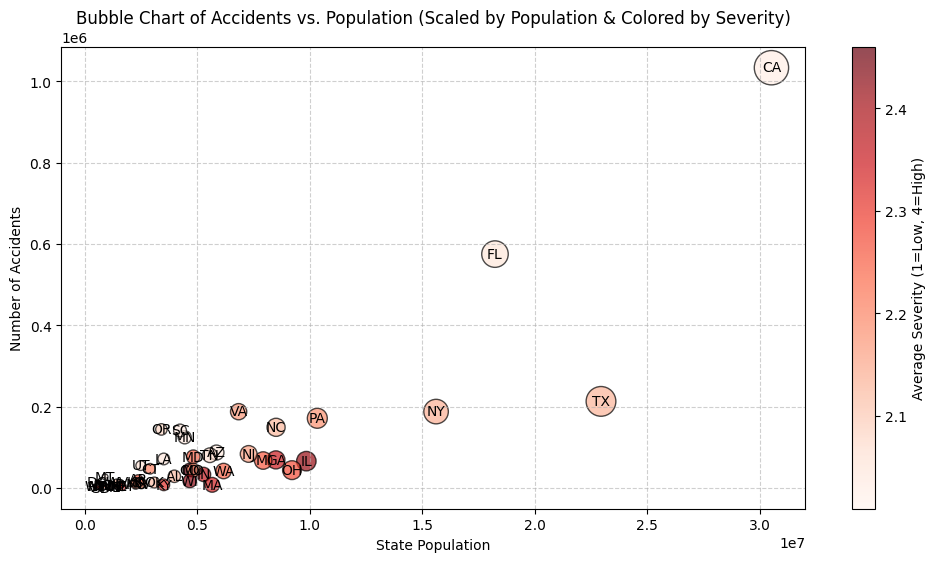

In [18]:
plot_bubble_chart(all_data_frame["cleaned_data_file_frame"], usa_2023_population_age_18_and_up_data_frame)


#### State population %age a Sev level

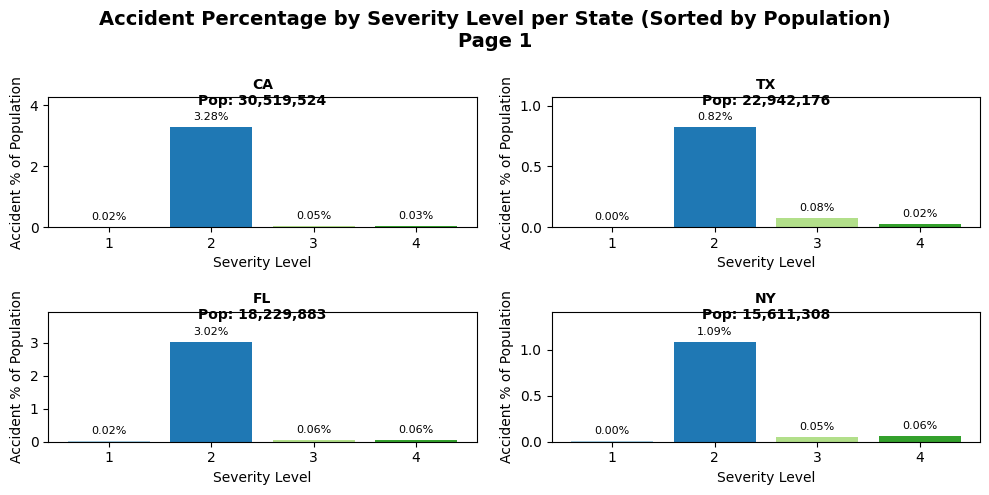

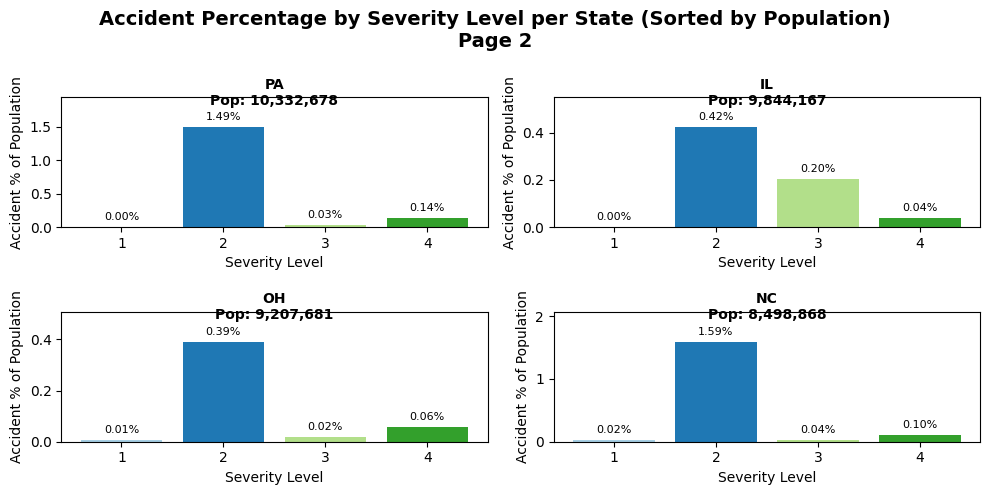

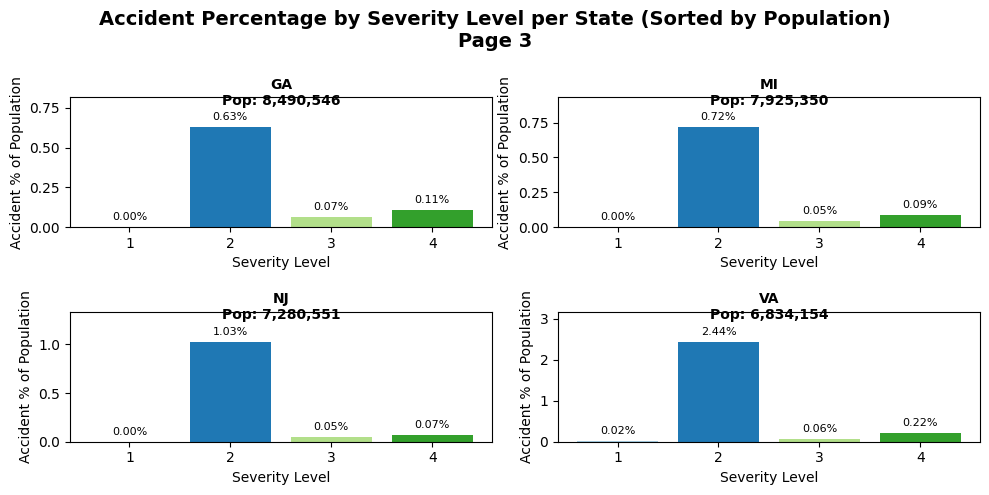

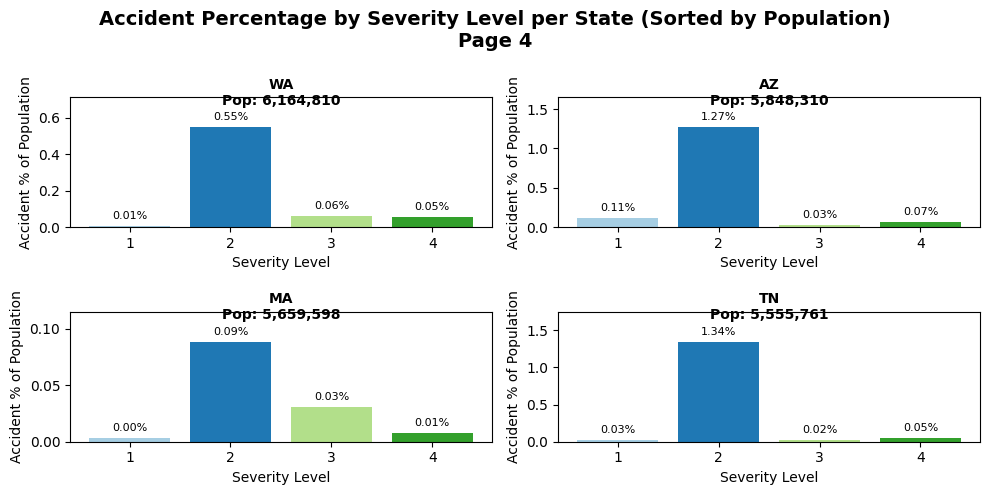

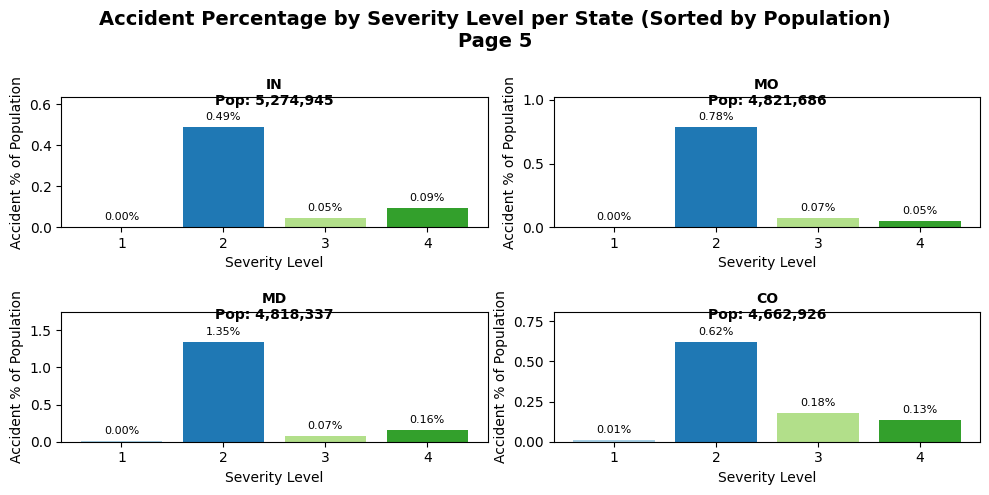

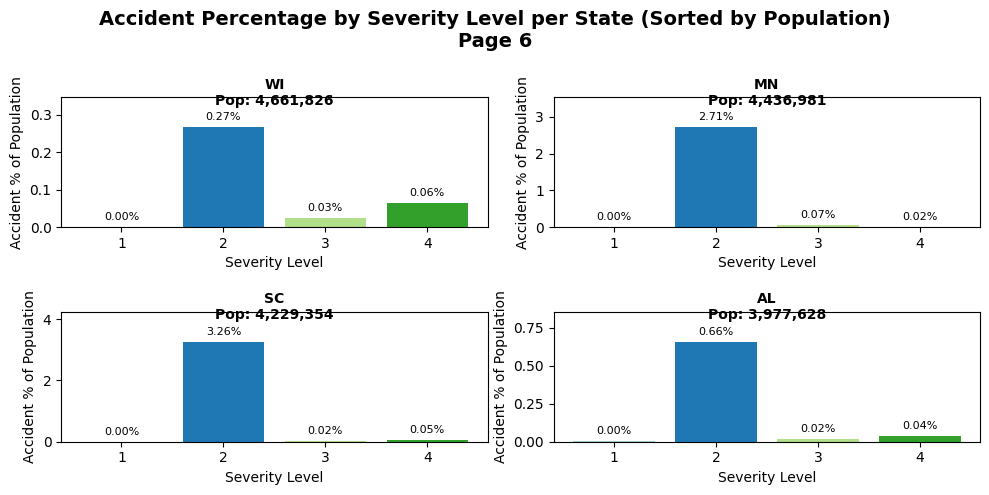

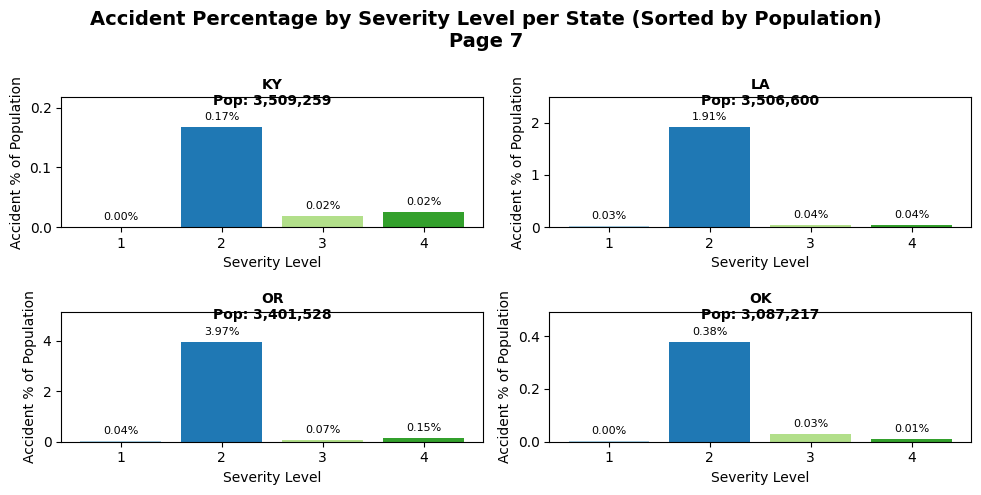

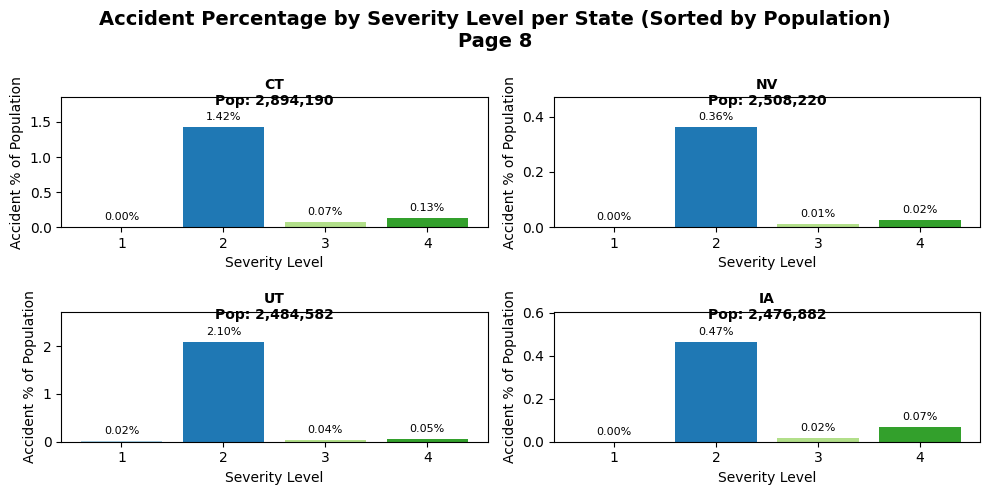

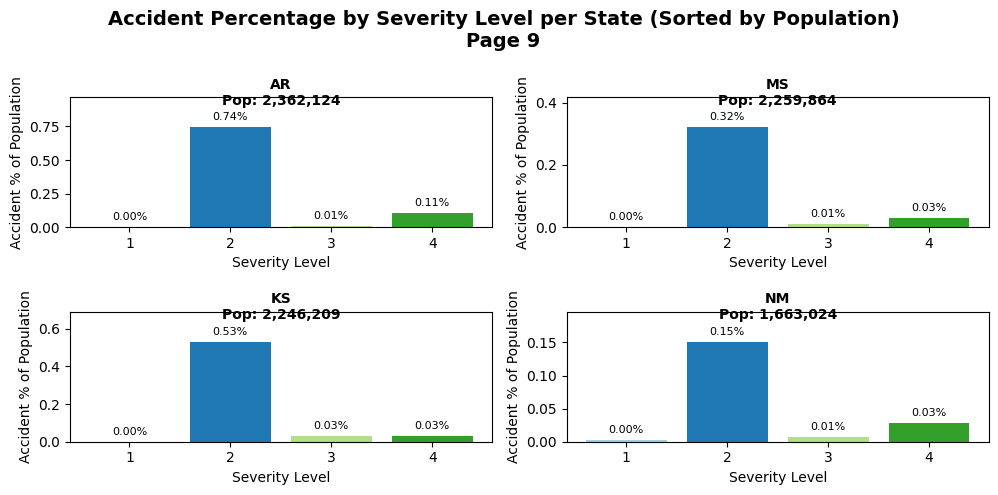

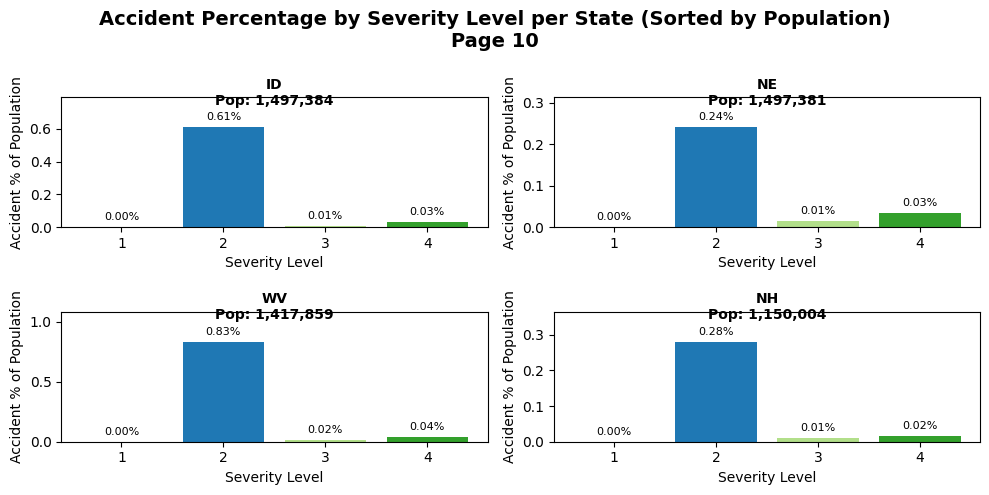

C:\Users\atul1\AppData\Local\Temp\ipykernel_26248\1892078778.py:250: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



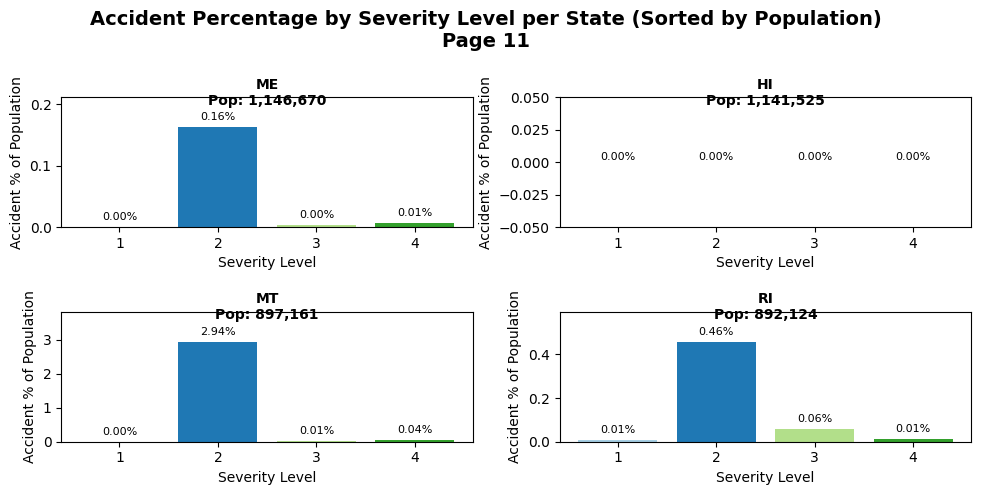

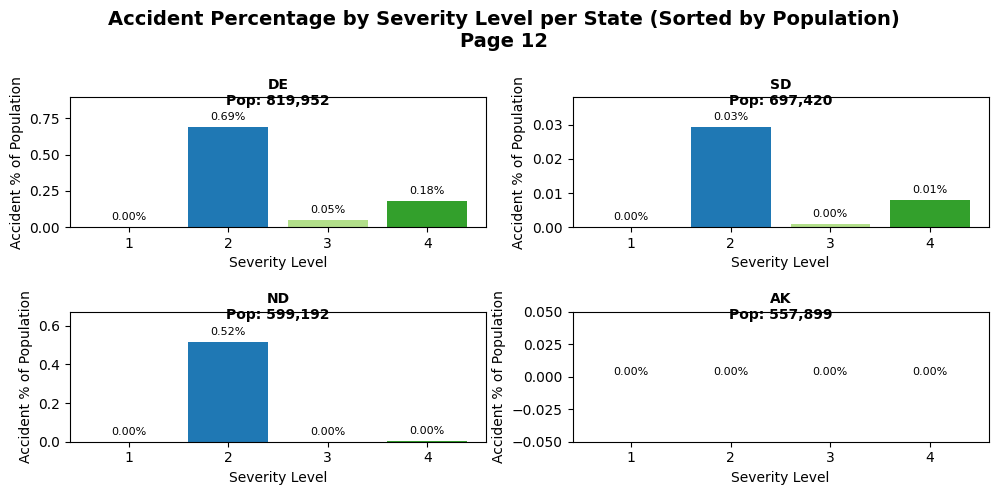

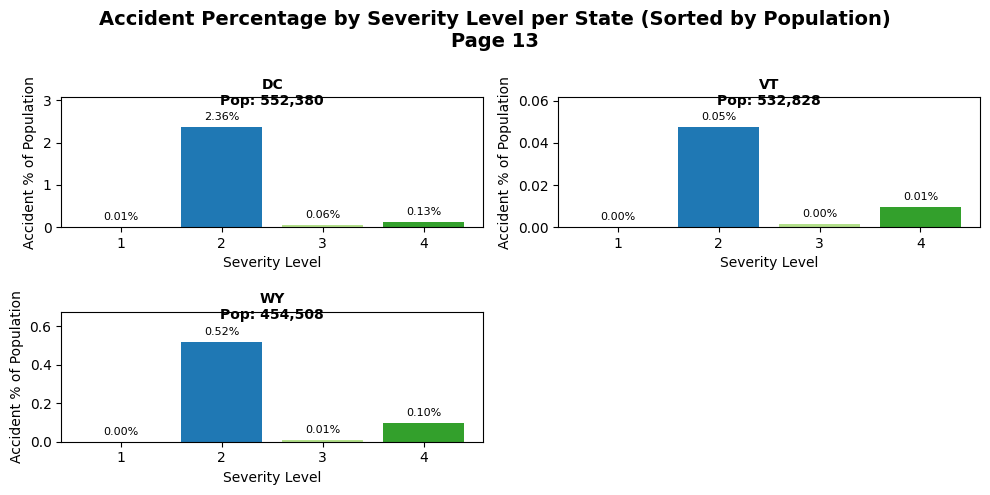

In [19]:
plot_paginated_accident_percentage_improved(all_data_frame["cleaned_data_file_frame"], usa_2023_population_age_18_and_up_data_frame)

### Chi-Square test Hypothesis test

In [31]:
def analyze_visibility_temperature_effect_on_severity(data_frame, num_bins=5, lower_quantile=0.10, upper_quantile=0.90):
    """
    Analyzes the effect of visibility and temperature on accident severity using a Chi-Square test.
    
    Outliers in "Visibility(mi)" and "Temperature(F)" are removed by keeping only rows within the specified quantiles.
    
    Null Hypothesis (H0): Visibility and Temperature have no significant effect on accident severity.
    Alternative Hypothesis (H1): Visibility and Temperature significantly affect accident severity.

    Parameters:
        data_frame (pd.DataFrame): The dataset containing accident details.
        num_bins (int): Number of bins to create for visibility and temperature dynamically.
        lower_quantile (float): Lower quantile cutoff for filtering (default is 0.10).
        upper_quantile (float): Upper quantile cutoff for filtering (default is 0.90).

    Returns:
        dict or None: Chi-square test results including chi-square value, p-value, and degrees of freedom,
                      or None if filtering results in no data.
    """

    # Checking if required columns exist
    required_columns = ["Visibility(mi)", "Temperature(F)", "Severity"]
    missing_columns = [col for col in required_columns if col not in data_frame.columns]
    if missing_columns:
        print(f"Error: Missing columns in dataset: {missing_columns}")
        print(f"Available columns: {data_frame.columns.tolist()}")
        return None

    # Selecting relevant columns
    tmp_df = data_frame[required_columns].copy()

    # Handling missing values: fill with the median values
    tmp_df.loc[:, "Visibility(mi)"] = tmp_df["Visibility(mi)"].fillna(tmp_df["Visibility(mi)"].median())
    tmp_df.loc[:, "Temperature(F)"] = tmp_df["Temperature(F)"].fillna(tmp_df["Temperature(F)"].median())

    # Filtering out outliers: keep only rows within the lower_quantile to upper_quantile for both columns
    vis_lower = tmp_df["Visibility(mi)"].quantile(lower_quantile)
    vis_upper = tmp_df["Visibility(mi)"].quantile(upper_quantile)
    tmp_df = tmp_df[(tmp_df["Visibility(mi)"] >= vis_lower) & (tmp_df["Visibility(mi)"] <= vis_upper)]
    
    temp_lower = tmp_df["Temperature(F)"].quantile(lower_quantile)
    temp_upper = tmp_df["Temperature(F)"].quantile(upper_quantile)
    tmp_df = tmp_df[(tmp_df["Temperature(F)"] >= temp_lower) & (tmp_df["Temperature(F)"] <= temp_upper)]
    
    # Check if any data remains after filtering
    if tmp_df.empty:
        print("No data remains after filtering for the specified quantile range.")
        return None

    # Dynamic Binning for Visibility using percentiles
    _, visibility_bins = pd.qcut(tmp_df["Visibility(mi)"], q=num_bins, retbins=True, labels=False, duplicates="drop")
    visibility_labels = [f"Bin {i+1} ({visibility_bins[i]:.1f} - {visibility_bins[i+1]:.1f} mi)" 
                         for i in range(len(visibility_bins)-1)]
    tmp_df["Visibility_Category"] = pd.qcut(tmp_df["Visibility(mi)"], q=num_bins, labels=visibility_labels, duplicates="drop")

    # Dynamic Binning for Temperature using percentiles
    _, temp_bins = pd.qcut(tmp_df["Temperature(F)"], q=num_bins, retbins=True, labels=False, duplicates="drop")
    temp_labels = [f"Bin {i+1} ({temp_bins[i]:.1f} - {temp_bins[i+1]:.1f}°F)" 
                   for i in range(len(temp_bins)-1)]
    tmp_df["Temperature_Category"] = pd.qcut(tmp_df["Temperature(F)"], q=num_bins, labels=temp_labels, duplicates="drop")

    # Creating a contingency table for Visibility, Temperature, and Severity
    contingency_table = pd.crosstab(index=[tmp_df["Visibility_Category"], tmp_df["Temperature_Category"]],
                                    columns=tmp_df["Severity"])

    # Check if the contingency table is empty
    if contingency_table.empty:
        print("Contingency table is empty after filtering. Consider using a less strict filtering criteria.")
        return None

    # Performing Chi-Square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print()
    # Printing results
    print("\nChi-Square Test Results:")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-Value: {p:.6f}")
    print(f"Degrees of Freedom: {dof}")

    # Interpretation
    alpha = 0.05
    if p < alpha:
        print("\nConclusion: Reject the Null Hypothesis (H0). Visibility and Temperature significantly affect accident severity.")
    else:
        print("\nConclusion: Fail to Reject the Null Hypothesis (H0). No significant effect of visibility and temperature on severity.")

    # Returning results as a dictionary
    return {
        "Chi-Square Statistic": chi2,
        "P-Value": p,
        "Degrees of Freedom": dof,
        "Contingency Table": contingency_table
    }

analyze_visibility_temperature_effect_on_severity(all_data_frame["cleaned_data_file_frame"])



Chi-Square Test Results:
Chi-Square Statistic: 3036.6006
P-Value: 0.000000
Degrees of Freedom: 12

Conclusion: Reject the Null Hypothesis (H0). Visibility and Temperature significantly affect accident severity.


{'Chi-Square Statistic': np.float64(3036.60056123279),
 'P-Value': np.float64(0.0),
 'Degrees of Freedom': 12,
 'Contingency Table': Severity                                        1       2      3      4
 Visibility_Category   Temperature_Category                             
 Bin 1 (5.0 - 10.0 mi) Bin 1 (37.0 - 51.0°F)  2487  575383  19995  28945
                       Bin 2 (51.0 - 61.0°F)  4908  585482  20339  24285
                       Bin 3 (61.0 - 69.0°F)  3978  515936  18148  20985
                       Bin 4 (69.0 - 77.0°F)  4526  592701  24298  26016
                       Bin 5 (77.0 - 85.0°F)  4881  494395  20494  18617}

# EDA for CA, FL and NY

C:\Users\atul1\AppData\Local\Temp\ipykernel_9088\2555056239.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=street_counts.values, y=street_counts.index, palette="magma", ax=ax)
C:\Users\atul1\AppData\Local\Temp\ipykernel_9088\2555056239.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=street_counts.values, y=street_counts.index, palette="magma", ax=ax)
C:\Users\atul1\AppData\Local\Temp\ipykernel_9088\2555056239.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=street_counts.values, y=street_counts.index, palette="magma", ax

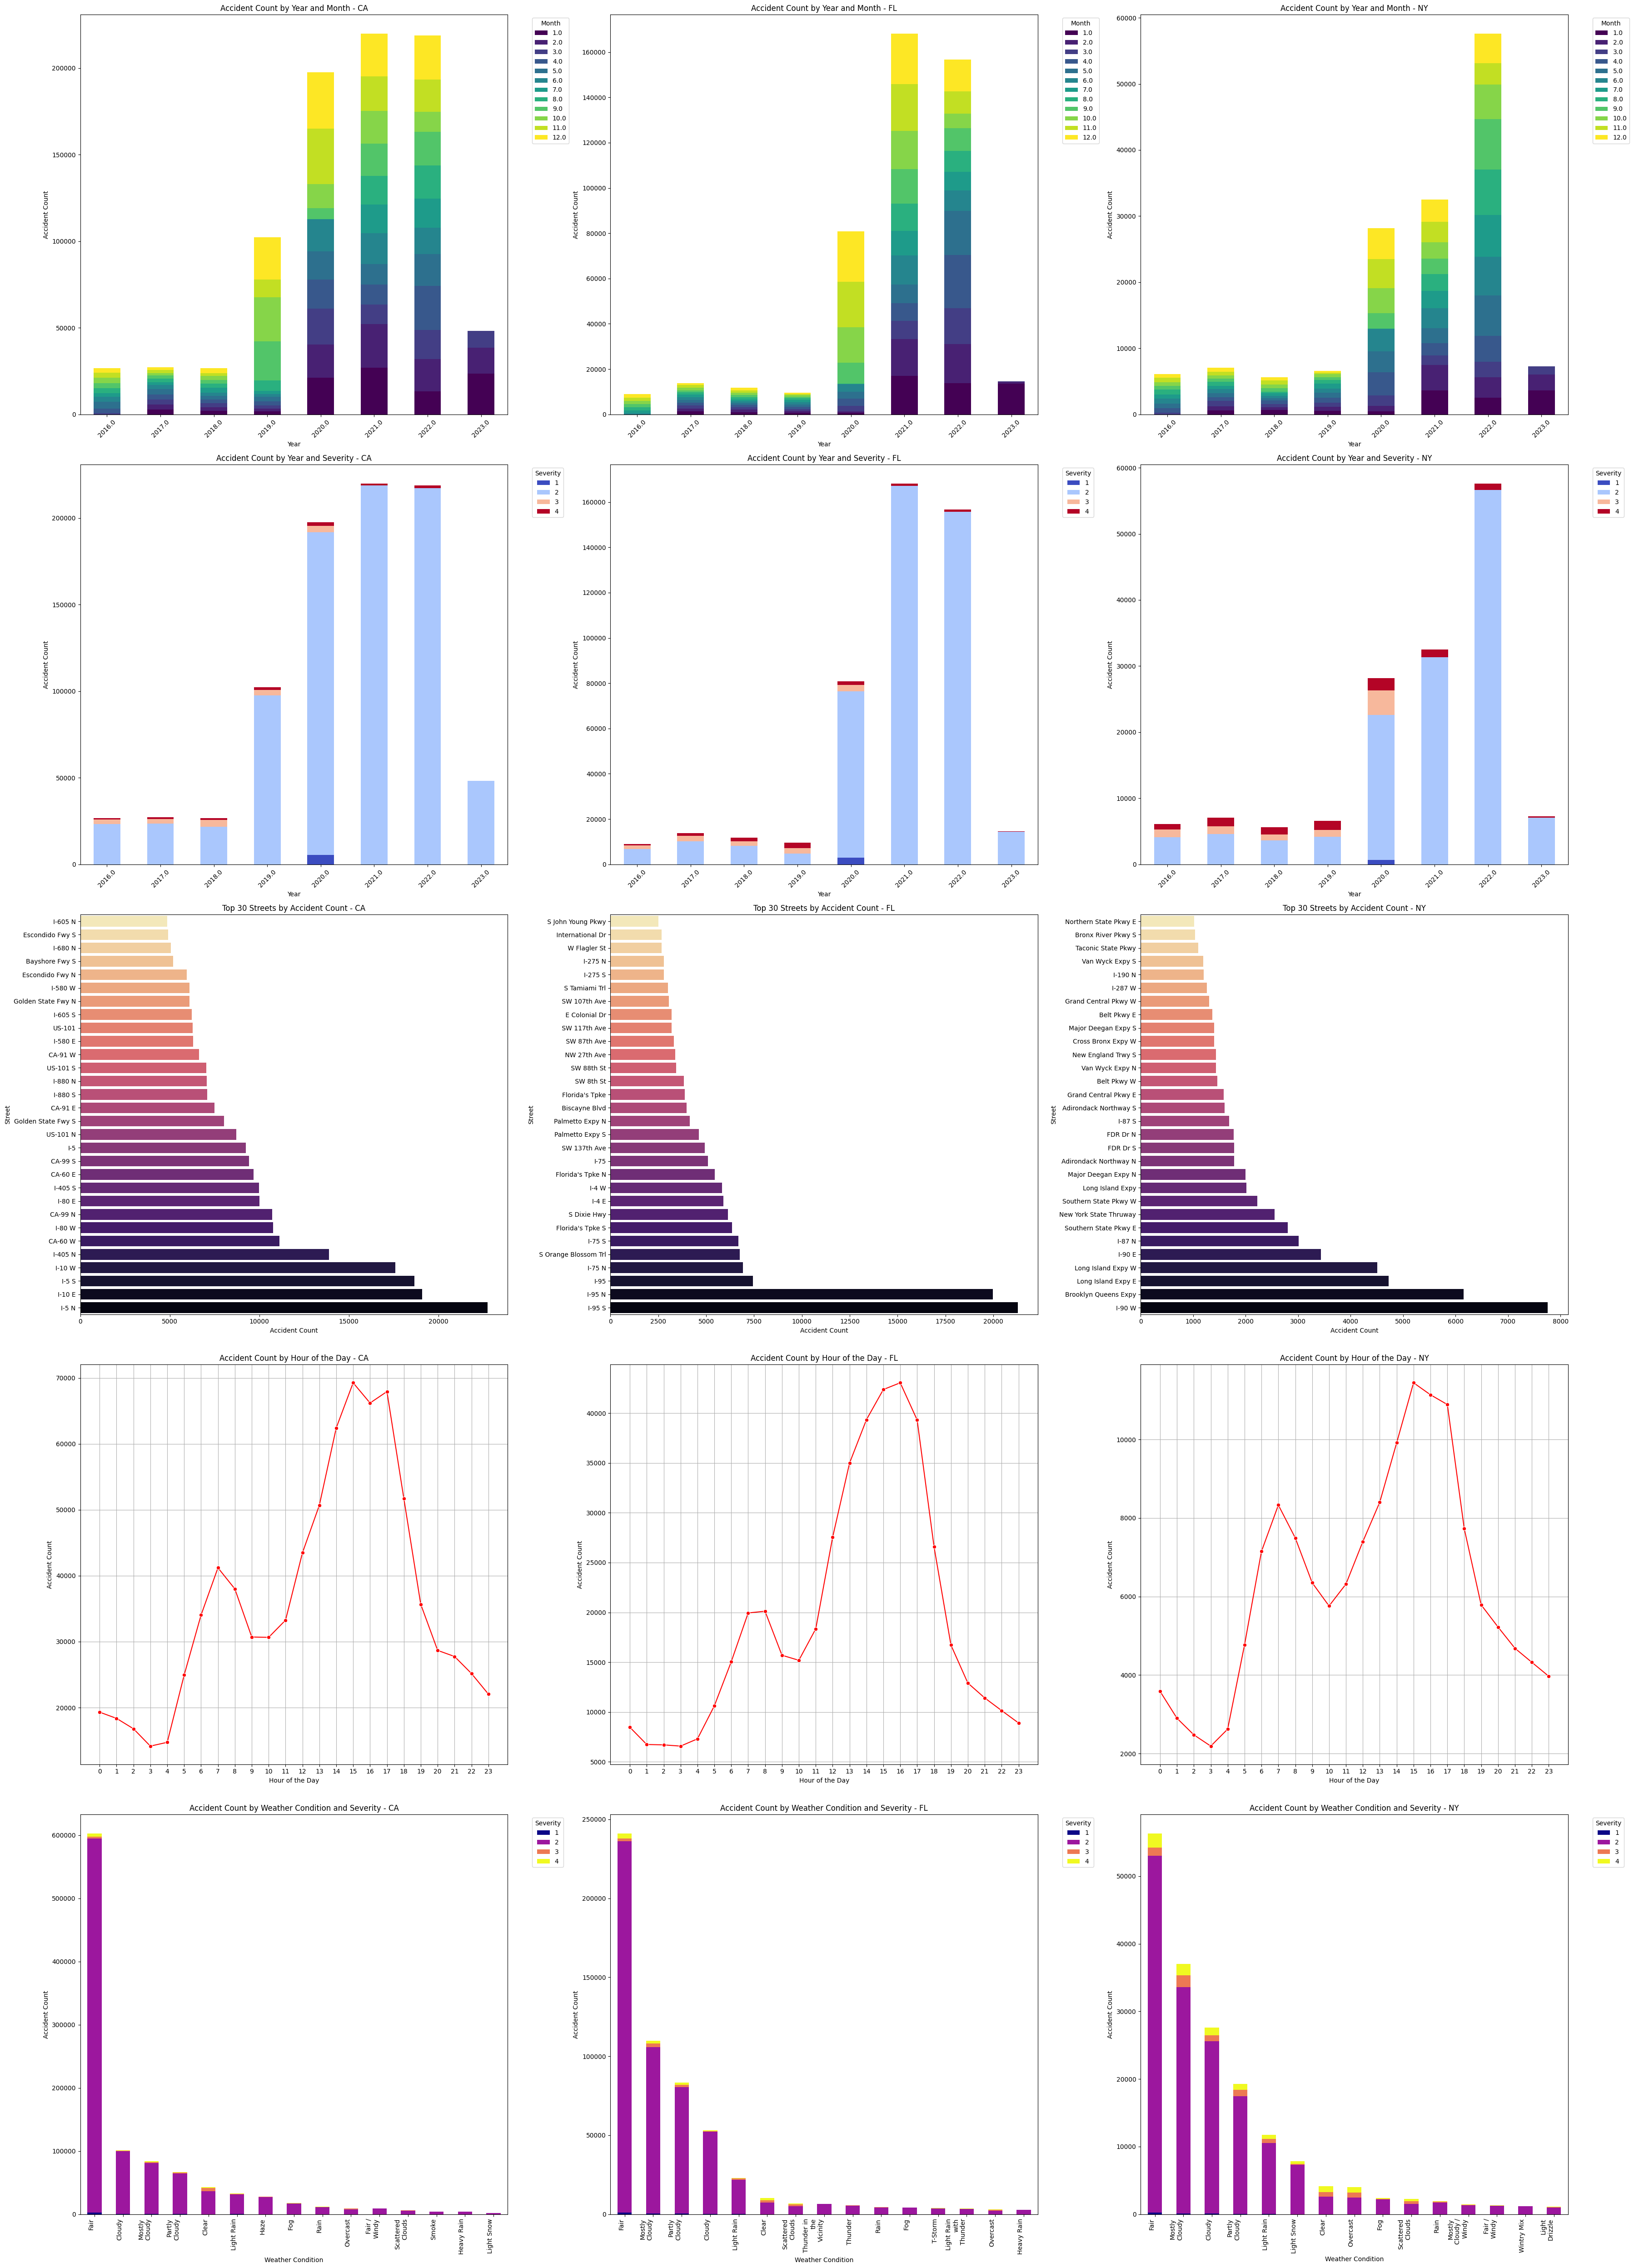

In [9]:
def plot_histogram_weather_condition_vs_accident_count(data_frame, state, ax):
    """Plots a histogram of accident count by weather condition."""
    weather_condition = data_frame["Weather_Condition"].value_counts()
    weather_condition.plot(kind="bar", color="skyblue", edgecolor="black", ax=ax)
    
    ax.set_xlabel("Weather Condition")
    ax.set_ylabel("Total Accidents")
    ax.set_title(f"Total Accidents by Weather Condition - {state}")
    ax.tick_params(axis="x", rotation=90)
    ax.grid(axis="y", linestyle="--", alpha=0.7)


def plot_accident_trend_by_month(data_frame, state, ax):
    """Plots a stacked bar chart for accident count by year and month."""
    
    # Ensure Start_Time is in datetime format
    if "Start_Time" not in data_frame.columns:
        print(f"Error: 'Start_Time' column missing in dataset for {state}")
        return

    if not np.issubdtype(data_frame["Start_Time"].dtype, np.datetime64):
        data_frame["Start_Time"] = pd.to_datetime(data_frame["Start_Time"], errors="coerce")

    # Extract Year and Month
    data_frame["Year"] = data_frame["Start_Time"].dt.year
    data_frame["Month"] = data_frame["Start_Time"].dt.month

    # Group by Year & Month
    accident_counts = data_frame.groupby(["Year", "Month"]).size().unstack()
    accident_counts.plot(kind="bar", stacked=True, colormap="viridis", ax=ax)

    # Formatting
    ax.set_xlabel("Year")
    ax.set_ylabel("Accident Count")
    ax.set_title(f"Accident Count by Year and Month - {state}")
    ax.legend(title="Month", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.tick_params(axis="x", rotation=45)



def plot_accident_trend_by_severity(data_frame, state, ax):
    """Plots a stacked bar chart for accident count by year and severity."""
    data_frame = data_frame.copy()
    data_frame["Year"] = data_frame["Start_Time"].dt.year

    accident_counts = data_frame.groupby(["Year", "Severity"]).size().unstack()
    accident_counts.plot(kind="bar", stacked=True, colormap="coolwarm", ax=ax)

    ax.set_xlabel("Year")
    ax.set_ylabel("Accident Count")
    ax.set_title(f"Accident Count by Year and Severity - {state}")
    ax.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.tick_params(axis="x", rotation=45)


def plot_top_30_streets(data_frame, state, ax):
    """Plots a bar chart of the top 30 streets with the highest accident counts."""
    street_counts = data_frame["Street"].value_counts().nlargest(30)
    sns.barplot(x=street_counts.values, y=street_counts.index, palette="magma", ax=ax)

    ax.set_xlabel("Accident Count")
    ax.set_ylabel("Street")
    ax.set_title(f"Top 30 Streets by Accident Count - {state}")
    ax.invert_yaxis()


def plot_accidents_by_hour(data_frame, state, ax):
    """Plots accident counts by hour of the day."""
    data_frame = data_frame.copy()
    data_frame["Hour"] = data_frame["Start_Time"].dt.hour
    hour_counts = data_frame["Hour"].value_counts().sort_index()

    sns.lineplot(x=hour_counts.index, y=hour_counts.values, marker="o", linestyle="-", color="red", ax=ax)

    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Accident Count")
    ax.set_title(f"Accident Count by Hour of the Day - {state}")
    ax.set_xticks(range(0, 24))
    ax.grid(True)


def plot_weather_vs_severity(data_frame, state, ax):

    # Group and filter top 15 weather conditions
    weather_severity_counts = data_frame.groupby(["Weather_Condition", "Severity"]).size().unstack()
    weather_severity_counts = weather_severity_counts.loc[weather_severity_counts.sum(axis=1).nlargest(15).index]

    # Plot
    weather_severity_counts.plot(kind="bar", stacked=True, colormap="plasma", ax=ax)

    # Adjust labels to avoid overlap
    ax.set_xlabel("Weather Condition")
    ax.set_ylabel("Accident Count")
    ax.set_title(f"Accident Count by Weather Condition and Severity - {state}")
    ax.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Rotate x-tick labels and wrap text
    ax.set_xticklabels(
        [textwrap.fill(label, 10) for label in weather_severity_counts.index],  # Wrap long labels
        rotation=90, ha="right"  # Rotate labels and align right
    )

    # Adjust layout to avoid clipping
    plt.subplots_adjust(bottom=0.3)


# -------------------- Generate Multi-State Subplots --------------------
def generate_subplots_for_states(states_data):
    """
    Generates a multi-state, multi-row plot where each row represents a type of graph,
    and each column represents a state.
    """
    plot_functions = [
        plot_accident_trend_by_month,
        plot_accident_trend_by_severity,
        plot_top_30_streets,
        plot_accidents_by_hour,
        plot_weather_vs_severity
    ]

    fig, axes = plt.subplots(nrows=len(plot_functions), ncols=len(states_data), figsize=(18 * 2, 25 * 2))

    for row_idx, plot_func in enumerate(plot_functions):
        for col_idx, (state, df) in enumerate(states_data.items()):
            ax = axes[row_idx, col_idx]
            plot_func(df, state, ax)

    plt.tight_layout()
    plt.show()

states_data = {
    "CA": all_data_frame["ca_data_frame"],
    "FL": all_data_frame["fl_data_frame"],
    "NY": all_data_frame["ny_data_frame"],
}

# Generate subplots for all states
generate_subplots_for_states(states_data)